In [110]:
import urllib
import pandas as pd
from typing import List

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#### Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for **January and February 2021**.

Note that you need **For-Hire Vehicle Trip Records**, not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

- [] 1054112
- [x] 1154112
- [] 1254112
- [] 1354112


In [23]:
TRIP_DATA_BASE_URL = "https://nyc-tlc.s3.amazonaws.com/trip+data"
DATASET_NAME = "fhv_tripdata"

In [44]:
def download_data(file_identifier: str, output_path="./data"):
    file_url = f'{TRIP_DATA_BASE_URL}/{DATASET_NAME}_{file_identifier}.parquet'
    file = urllib.request.FancyURLopener()
    file.retrieve(file_url, f"{output_path}/{DATASET_NAME}_{file_identifier}.parquet")
    
def read_parquet_to_df(file_identifier:str):
    file_name = f'{DATASET_NAME}_{file_identifier}.parquet'
    df = pd.read_parquet(f'./data/{file_name}', engine="pyarrow")
    return df

In [45]:
df_january=read_parquet_to_df(file_identifier="2021-01") # 8078784
df_february=read_parquet_to_df(file_identifier="2021-02") # 7263844

In [49]:
df_january.shape

(1154112, 7)

#### Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes. 

What's the average trip duration in January?

- [] 15.16
- [x] 19.16
- [] 24.16
- [] 29.16


In [97]:
def find_mean_duration_time(df:pd.DataFrame):
    df = df_january
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    # df = df[(df.duration >= 1) & (df.duration <= 60)]
    return df

In [99]:
df_january = read_parquet_to_df(file_identifier="2021-01")

In [100]:
df_january = find_mean_duration_time(df_january)
df_january["duration"].mean()

19.167224093791006

### Data Prepration

Check the distribution of the duration variable. There are some outliers. 

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop? 

In [103]:
print(df_january.shape) 
df_january = df_january[(df_january.duration >= 1) & (df_january.duration <= 60)]
print(df_january.shape)

(1154112, 8)
(1109826, 8)


#### Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs. 

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

- [] 53%
- [] 63%
- [] 73%
- [x] 83%

In [104]:
df_january.fillna({'PUlocationID':-1, 'DOlocationID':-1}, inplace=True)

/var/folders/jq/rts_nxdd6r35jfsprmkf6r4r0000gn/T/ipykernel_22145/2788994029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_january.fillna({'PUlocationID':-1, 'DOlocationID':-1}, inplace=True)


In [105]:
(df_january['PUlocationID'].value_counts()/df['PUlocationID'].count())*100

-1.0      83.527328
 221.0     0.750568
 206.0     0.612438
 129.0     0.484671
 115.0     0.367805
            ...    
 111.0     0.000451
 27.0      0.000360
 34.0      0.000270
 2.0       0.000180
 110.0     0.000090
Name: PUlocationID, Length: 262, dtype: float64

#### Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

- [x] 2
- [] 152
- [] 352
- [] 525
- [] 725

In [116]:
df = df_january

In [117]:
categorical = ["PUlocationID", "DOlocationID"]
train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
feature_matrix=pd.DataFrame(X_train.todense(), columns=dv.feature_names_)

target = "duration"
y_train = df[target].values

#### Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

- [] 5.52
- [x] 10.52
- [] 15.52
- [] 20.52

In [138]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519421155469

/Users/iremertuerk/workspace-personal/mlops-zoomcamp/.venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/iremertuerk/workspace-personal/mlops-zoomcamp/.venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


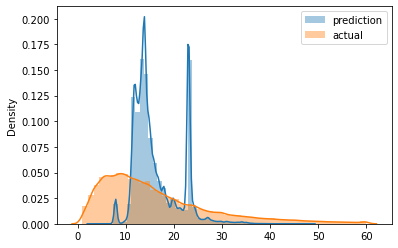

In [139]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

#### Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021). 

What's the RMSE on validation?

- [] 6.01
- [x] 11.01
- [] 16.01
- [] 21.01

In [131]:
def download_data(file_identifier: str, output_path="./data"):
    file_url = f'{TRIP_DATA_BASE_URL}/{DATASET_NAME}_{file_identifier}.parquet'
    file = urllib.request.FancyURLopener()
    file.retrieve(file_url, f"{output_path}/{DATASET_NAME}_{file_identifier}.parquet")
    
def read_parquet_to_df(file_identifier:str):
    file_name = f'{DATASET_NAME}_{file_identifier}.parquet'
    df = pd.read_parquet(f'./data/{file_name}', engine="pyarrow")
    return df

In [132]:
def preprocess(file_identifier:str):
    df = read_parquet_to_df(file_identifier)
    # 2. Calculate duration column
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # 3. Filter rows
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    # 4. Fill NAs
    df.fillna({'PUlocationID':-1, 'DOlocationID':-1}, inplace=True)
    
    categorical = ["PUlocationID", "DOlocationID"]
    df[categorical] = df[categorical].astype(str)

    return df

In [134]:
df_train = preprocess('2021-01')
df_validate = preprocess('2021-02')

In [135]:
categorical = ["PUlocationID", "DOlocationID"]
dv = DictVectorizer()

# Prepare features
train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

validate_dicts = df_validate[categorical].to_dict(orient='records')
X_validate = dv.transform(validate_dicts)

# Prepare values
target = 'duration'
y_train = df_train[target].values
y_validate = df_validate[target].values

In [137]:
# Train and Calculate the RSME
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_validate)

mean_squared_error(y_validate, y_pred, squared=False)

11.01428736186454